In [ ]:
!nvidia-smi

Tue Nov  4 11:52:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!unzip images.zip

Archive:  images.zip
   creating: images/
  inflating: images/team19_139.jpg   
  inflating: images/team19_1759150167457.jpg  
  inflating: images/team19_1759150171670.jpg  
  inflating: images/team19_1759150533744.jpg  
  inflating: images/team19_1759150566575.jpg  
  inflating: images/team19_1759151063226.jpg  
  inflating: images/team19_1759151065948.jpg  
  inflating: images/team19_1759151071735.jpg  
  inflating: images/team19_1759151075529.jpg  
  inflating: images/team19_1759151172870.jpg  
  inflating: images/team19_1759152072987.jpg  
  inflating: images/team19_20191005181729_2.jpg  
  inflating: images/team19_71p++9K+x3L._UF350,350_QL80_.jpg  
  inflating: images/team19_BagBalmMoisturizingSoap_3.9oz_4.jpg  
  inflating: images/team19_BBS_694c45df-7b39-486e-8502-d24f0f0fb456.jpg  
  inflating: images/team19_il_340x270.4258371409_f2hm.jpg  
  inflating: images/team19_il_340x270.6392176763_6uy0.jpg  
  inflating: images/team19_IMG-20250929-WA0021.jpg  
  inflating: images/team19

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.6 MB/s eta 0:00:00


In [ ]:
import os
import json
import random
from typing import Dict, List, Any

import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset

from datasets import Dataset as HFDataset
import evaluate

from transformers import (
    AutoImageProcessor,
    MobileViTModel,
    Trainer,
    TrainingArguments,
    set_seed,
)

In [ ]:
# -------------------------
# Configuration
# -------------------------
CSV_PATH = "/content/newlabels.csv"
IMG_ROOT = "/"
OUTPUT_DIR = "/content/mobilevit-multitask-finetuned"
MODEL_NAME = "apple/mobilevit-small"
BATCH_SIZE = 16
NUM_EPOCHS = 10
LR = 2e-5
WEIGHT_DECAY = 1e-4
SEED = 42
MISSING_TOKEN = "N/A"

# specify your chosen attribute tasks explicitly
ATTRIBUTE_TASKS = ["color", "material", "condition", "size"]

In [ ]:
# -------------------------
# Helpers
# -------------------------
def set_all_seeds(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    set_seed(seed)

def ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)

In [ ]:
# -------------------------
# Robust CSV Parsing (your functions)
# -------------------------
def parse_attributes(attr_str):
    """Parse 'color:white;material:plastic' → {'color': 'white', 'material': 'plastic'}"""
    if pd.isna(attr_str):
        return {}
    attributes = {}
    try:
        for item in attr_str.split(';'):
            if ':' in item:
                key, value = item.split(':', 1)
                attributes[key.strip()] = value.strip()
    except Exception as e:
        print(f"Error parsing attribute string: {attr_str} | Error: {e}")
    return attributes

def preprocess_dataframe(csv_path, attribute_task_list):
    """Load the single CSV, parse only the specified attributes, and return train/val splits + tasks"""
    print(f"Loading data from {csv_path}...")
    df = pd.read_csv(csv_path)

    print("Parsing 'attributes' column...")
    attr_dicts = df['attributes'].apply(parse_attributes)
    attr_df = pd.DataFrame(attr_dicts.tolist())

    print(f"Filtering for specified attributes: {attribute_task_list}")
    found_attributes = [col for col in attribute_task_list if col in attr_df.columns]
    missing_attributes = [col for col in attribute_task_list if col not in attr_df.columns]

    if missing_attributes:
        print(f"⚠️ Warning: Missing attributes not found in CSV: {missing_attributes}")

    attr_df = attr_df[found_attributes]
    df = pd.concat([df, attr_df], axis=1)
    df[found_attributes] = df[found_attributes].fillna(MISSING_TOKEN)

    task_columns = ["class_label"] + found_attributes

    df_train = df[df["split"].str.lower() == "train"].reset_index(drop=True)
    df_val = df[df["split"].str.lower().isin(["val", "valid", "validation"])].reset_index(drop=True)

    print(f"✅ Created {len(df_train)} training samples and {len(df_val)} validation samples.")
    return df_train, df_val, task_columns

In [ ]:
# -------------------------
# Label mapping
# -------------------------
def make_label_maps(df_trainval: pd.DataFrame, tasks: List[str]) -> Dict[str, Dict[str, Any]]:
    maps = {}
    for t in tasks:
        uniq = sorted(df_trainval[t].fillna(MISSING_TOKEN).astype(str).unique())
        if MISSING_TOKEN not in uniq:
            uniq.append(MISSING_TOKEN)
        label2id = {lbl: i for i, lbl in enumerate(uniq)}
        id2label = {i: lbl for lbl, i in label2id.items()}
        maps[t] = {"label2id": label2id, "id2label": id2label}
    return maps

def apply_label_maps(df: pd.DataFrame, tasks: List[str], label_maps: Dict[str, Dict[str, Any]]) -> pd.DataFrame:
    for t in tasks:
        l2i = label_maps[t]["label2id"]
        df[t] = df[t].fillna(MISSING_TOKEN).astype(str)
        df[f"{t}_id"] = df[t].map(lambda x: l2i.get(x, l2i[MISSING_TOKEN]))
    return df

In [ ]:
# -------------------------
# Dataset
# -------------------------
class MultiTaskImageDataset(Dataset):
    def __init__(self, df, img_root, tasks, processor):
        self.df = df.reset_index(drop=True)
        self.img_root = img_root
        self.tasks = tasks
        self.processor = processor
        self.label_cols = [f"{t}_id" for t in tasks]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row["image_path"]
        img_path = os.path.join(self.img_root, path) if self.img_root not in ("", "/") else path
        image = Image.open(img_path).convert("RGB")

        inputs = self.processor(images=image, return_tensors="pt")
        pixel_values = inputs["pixel_values"].squeeze()  # [3, H, W]
        labels = torch.tensor([int(row[col]) for col in self.label_cols], dtype=torch.long)

        return {"pixel_values": pixel_values, "labels": labels}

# -------------------------
# Model
# -------------------------
class MultiTaskMobileViT(nn.Module):
    def __init__(self, model_name: str, num_labels_per_task: List[int], dropout: float = 0.1):
        super().__init__()
        self.backbone = MobileViTModel.from_pretrained(model_name)
        feat_dim = 640
        self.tasks = len(num_labels_per_task)
        self.num_labels_per_task = num_labels_per_task

        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Dropout(dropout),
                nn.Linear(feat_dim, nlab),
            ) for nlab in num_labels_per_task
        ])
        self.criterion = nn.CrossEntropyLoss()
        self.offsets = np.cumsum([0] + num_labels_per_task).tolist()

    def forward(self, pixel_values=None, labels=None, **kwargs):
        outputs = self.backbone(pixel_values=pixel_values)
        features = outputs.pooler_output  # [B, hidden_dim]

        logits_per_task = [head(features) for head in self.heads]
        logits_concat = torch.cat(logits_per_task, dim=-1)

        loss = None
        if labels is not None:
            losses = [self.criterion(logits_per_task[i], labels[:, i]) for i in range(self.tasks)]
            loss = torch.stack(losses).mean()

        return {"loss": loss, "logits": logits_concat}

In [ ]:
# -------------------------
# Collator
# -------------------------
def collate_fn(batch):
    pixel_values = torch.stack([b["pixel_values"] for b in batch], dim=0)
    labels = torch.stack([b["labels"] for b in batch], dim=0)
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
# -------------------------
# Metrics
# -------------------------
def build_compute_metrics(tasks: List[str], num_labels_per_task: List[int]):
    accuracy = evaluate.load("accuracy")
    offsets = np.cumsum([0] + num_labels_per_task).tolist()

    def compute_metrics(eval_pred):
        preds_concat, labels = eval_pred
        per_task_acc = {}
        per_task_scores = []

        for i, task in enumerate(tasks):
            start, end = offsets[i], offsets[i + 1]
            logits_t = preds_concat[:, start:end]
            preds_t = logits_t.argmax(axis=-1)
            acc = accuracy.compute(predictions=preds_t, references=labels[:, i])["accuracy"]
            per_task_acc[task] = acc
            per_task_scores.append(acc)

        avg_acc = float(np.mean(per_task_scores))
        metrics = {f"{t}_accuracy": v for t, v in per_task_acc.items()}
        metrics["average_accuracy"] = avg_acc
        return metrics

    return compute_metrics

In [ ]:
# -------------------------
# Main
# -------------------------
def main():
    ensure_dir(OUTPUT_DIR)
    set_all_seeds(SEED)

    df_train, df_val, tasks = preprocess_dataframe(CSV_PATH, ATTRIBUTE_TASKS)
    df_trainval = pd.concat([df_train, df_val])

    label_maps = make_label_maps(df_trainval, tasks)
    df_train = apply_label_maps(df_train, tasks, label_maps)
    df_val = apply_label_maps(df_val, tasks, label_maps)

    num_labels_per_task = [len(label_maps[t]["label2id"]) for t in tasks]
    print("Label counts per task:", dict(zip(tasks, num_labels_per_task)))

    with open(os.path.join(OUTPUT_DIR, "label_maps.json"), "w") as f:
        json.dump(label_maps, f, indent=2)

    processor = AutoImageProcessor.from_pretrained(MODEL_NAME)

    train_ds = MultiTaskImageDataset(df_train, IMG_ROOT, tasks, processor)
    val_ds = MultiTaskImageDataset(df_val, IMG_ROOT, tasks, processor)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MultiTaskMobileViT(MODEL_NAME, num_labels_per_task=num_labels_per_task)
    model.to(device)
    compute_metrics = build_compute_metrics(tasks, num_labels_per_task)

    args = TrainingArguments(
        output_dir=OUTPUT_DIR,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=NUM_EPOCHS,
        learning_rate=LR,
        weight_decay=WEIGHT_DECAY,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="average_accuracy",
        greater_is_better=True,
        remove_unused_columns=False,
        logging_steps=50,
        report_to=["none"],
        fp16=True,  # enables mixed precision for Colab
        seed=SEED,
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=None,
        data_collator=collate_fn,
        compute_metrics=compute_metrics,
    )

    print("\n🚀 Starting training...")
    trainer.train()

    print("\n✅ Validation Results:")
    val_metrics = trainer.evaluate()
    for k, v in val_metrics.items():
        if isinstance(v, (float, int)):
            print(f"{k}: {v:.4f}")

    print("\n💾 Saving final model...")
    trainer.save_model(OUTPUT_DIR)
    with open(os.path.join(OUTPUT_DIR, "tasks.json"), "w") as f:
        json.dump({"tasks": tasks, "num_labels_per_task": num_labels_per_task}, f, indent=2)

    print("\n✅ Done.")

In [ ]:
main()

Loading data from /content/newlabels.csv...
Parsing 'attributes' column...
Filtering for specified attributes: ['color', 'material', 'condition', 'size']
✅ Created 449 training samples and 149 validation samples.
Label counts per task: {'class_label': 11, 'color': 29, 'material': 7, 'condition': 4, 'size': 4}


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/22.5M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/22.4M [00:00<?, ?B/s]

/tmp/ipython-input-976186232.py:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



🚀 Starting training...


Epoch,Training Loss,Validation Loss,Class Label Accuracy,Color Accuracy,Material Accuracy,Condition Accuracy,Size Accuracy,Average Accuracy
1,No log,2.068420,0.114094,0.087248,0.201342,0.395973,0.442953,0.248322
2,2.077500,2.060534,0.161074,0.093960,0.221477,0.463087,0.395973,0.267114
3,2.077500,2.050647,0.181208,0.087248,0.261745,0.496644,0.449664,0.295302
4,2.048000,2.038795,0.234899,0.114094,0.355705,0.543624,0.536913,0.357047
5,2.048000,2.026215,0.248322,0.100671,0.335570,0.510067,0.570470,0.353020
6,2.022000,2.023171,0.295302,0.114094,0.382550,0.550336,0.557047,0.379866
7,1.999600,2.006658,0.308725,0.107383,0.429530,0.610738,0.711409,0.433557
8,1.999600,2.011135,0.288591,0.107383,0.389262,0.563758,0.664430,0.402685
9,1.983900,2.000082,0.315436,0.114094,0.436242,0.617450,0.718121,0.440268
10,1.983900,2.002061,0.308725,0.114094,0.422819,0.597315,0.657718,0.420134



✅ Validation Results:


eval_loss: 2.0001
eval_class_label_accuracy: 0.3154
eval_color_accuracy: 0.1141
eval_material_accuracy: 0.4362
eval_condition_accuracy: 0.6174
eval_size_accuracy: 0.7181
eval_average_accuracy: 0.4403
eval_runtime: 0.9209
eval_samples_per_second: 161.7950
eval_steps_per_second: 10.8590
epoch: 10.0000

💾 Saving final model...

✅ Done.


In [ ]:
!zip -r mobilevit_small_1.zip /content/mobilevit-multitask-finetuned

  adding: content/mobilevit-multitask-finetuned/ (stored 0%)
  adding: content/mobilevit-multitask-finetuned/checkpoint-232/ (stored 0%)
  adding: content/mobilevit-multitask-finetuned/checkpoint-232/optimizer.pt (deflated 9%)
  adding: content/mobilevit-multitask-finetuned/checkpoint-232/trainer_state.json (deflated 77%)
  adding: content/mobilevit-multitask-finetuned/checkpoint-232/scaler.pt (deflated 64%)
  adding: content/mobilevit-multitask-finetuned/checkpoint-232/scheduler.pt (deflated 61%)
  adding: content/mobilevit-multitask-finetuned/checkpoint-232/model.safetensors (deflated 7%)
  adding: content/mobilevit-multitask-finetuned/checkpoint-232/rng_state.pth (deflated 26%)
  adding: content/mobilevit-multitask-finetuned/checkpoint-232/training_args.bin (deflated 53%)
  adding: content/mobilevit-multitask-finetuned/checkpoint-203/ (stored 0%)
  adding: content/mobilevit-multitask-finetuned/checkpoint-203/optimizer.pt (deflated 9%)
  adding: content/mobilevit-multitask-finetuned/

In [ ]:
# =========================
# Multi-task MobileViT — Single Random Image Inference (GPU)
# =========================

import os, json, random, torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from transformers import AutoImageProcessor, MobileViTModel
import torch.nn as nn

# ----- CONFIG -----
MODEL_DIR  = "/content/mobilevit-multitask-finetuned"
CHECKPOINT = "/content/mobilevit-multitask-finetuned/model.safetensors"
BASE_MODEL = "apple/mobilevit-small"
IMAGE_DIR  = "/content/images"   # folder containing your test images
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Using device: {DEVICE}")

# ----- Define model wrapper -----
class MultiTaskMobileViT(nn.Module):
    def __init__(self, model_name: str, num_labels_per_task: list, dropout: float = 0.1):
        super().__init__()
        self.backbone = MobileViTModel.from_pretrained(model_name)
        feat_dim = 640
        self.tasks = len(num_labels_per_task)
        self.num_labels_per_task = num_labels_per_task
        self.heads = nn.ModuleList([
            nn.Sequential(nn.Dropout(dropout), nn.Linear(feat_dim, nlab))
            for nlab in num_labels_per_task
        ])
        self.offsets = np.cumsum([0] + num_labels_per_task).tolist()

    def forward(self, pixel_values):
        outputs = self.backbone(pixel_values=pixel_values)
        feats = outputs.pooler_output
        logits_per_task = [head(feats) for head in self.heads]
        logits_concat = torch.cat(logits_per_task, dim=-1)
        return {"logits": logits_concat}

# ----- Load model + label maps -----
def load_model(model_dir, checkpoint_path, base_model, device):
    with open(os.path.join(model_dir, "tasks.json"), "r") as f:
        task_info = json.load(f)
    tasks = task_info["tasks"]
    num_labels_per_task = task_info["num_labels_per_task"]

    with open(os.path.join(model_dir, "label_maps.json"), "r") as f:
        label_maps = json.load(f)
    id2label = {t: {int(k): v for k, v in maps["id2label"].items()} for t, maps in label_maps.items()}

    print(f"🔹 Loading weights from: {checkpoint_path}")
    weights = load_file(checkpoint_path)

    model = MultiTaskMobileViT(base_model, num_labels_per_task)
    model.load_state_dict(weights, strict=True)
    model.to(device).eval()

    processor = AutoImageProcessor.from_pretrained(base_model)
    offsets = np.cumsum([0] + num_labels_per_task).tolist()
    return model, processor, tasks, id2label, offsets

# ----- Prediction -----
@torch.no_grad()
def predict_single(model, processor, tasks, id2label, offsets, image, device):
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.autocast(device_type="cuda", enabled=(device.type == "cuda")):
        logits = model(pixel_values=inputs["pixel_values"])["logits"]

    preds = {}
    for t_idx, task in enumerate(tasks):
        s, e = offsets[t_idx], offsets[t_idx + 1]
        pred_id = int(logits[0, s:e].argmax(-1).item())
        preds[task] = id2label[task].get(pred_id, f"ID_{pred_id}")
    return preds

# ----- Visualize -----
def visualize(image, preds):
    plt.imshow(image)
    plt.axis("off")
    title = f"{preds['class_label']}\n" + ", ".join(
        [f"{k}: {v}" for k, v in preds.items() if k != "class_label"][:4]
    )
    plt.title(title, fontsize=10)
    plt.show()

# ----- Main -----
def main():
    model, processor, tasks, id2label, offsets = load_model(MODEL_DIR, CHECKPOINT, BASE_MODEL, DEVICE)

    # Randomly select one image from your test folder
    all_images = [os.path.join(IMAGE_DIR, f)
                  for f in os.listdir(IMAGE_DIR)
                  if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    if not all_images:
        raise ValueError(f"No images found in {IMAGE_DIR}")
    image_path = random.choice(all_images)
    print(f"\n🎯 Selected image: {os.path.basename(image_path)}")

    # Load and predict
    image = Image.open(image_path).convert("RGB")
    preds = predict_single(model, processor, tasks, id2label, offsets, image, DEVICE)

    # Show results
    print("\n=== Prediction for this image ===")
    print(f"Class: {preds['class_label']}")
    for t, v in preds.items():
        if t != "class_label":
            print(f"  {t}: {v}")

    visualize(image, preds)

🔥 Using device: cuda


🔹 Loading weights from: /content/mobilevit-multitask-finetuned/model.safetensors

🎯 Selected image: team19_IMG_20250929_180528.jpg

=== Prediction for this image ===
Class: electronics_accessories_keyboard
  color: white
  material: plastic
  condition: used
  size: medium


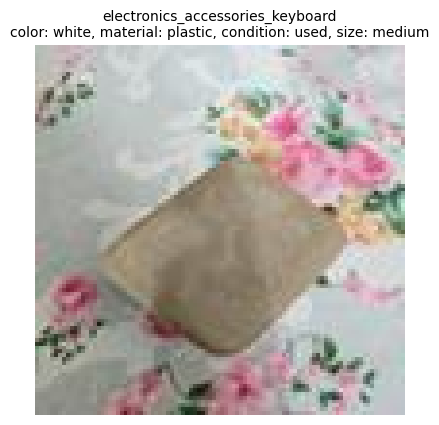

In [ ]:
main()

retrieval system

In [ ]:
# =====================================
# 🔍 MobileViT Retrieval System (search-index based)
# =====================================

import os, json, torch, pandas as pd, numpy as np
from PIL import Image
from tqdm.auto import tqdm
from safetensors.torch import load_file
from transformers import AutoImageProcessor, MobileViTModel
import torch.nn as nn
import spacy
import matplotlib.pyplot as plt
import random

# ----- CONFIG -----
MODEL_DIR = "/content/mobilevit-multitask-finetuned"
CHECKPOINT = "/content/mobilevit-multitask-finetuned/model.safetensors"
CSV_PATH = "/content/newlabels.csv"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Using device: {DEVICE}")

# ----- LOAD LABEL MAPS -----
with open(os.path.join(MODEL_DIR, "label_maps.json"), "r") as f:
    label_maps = json.load(f)
id_to_label = {t: {int(k): v for k, v in maps["id2label"].items()} for t, maps in label_maps.items()}
label_to_id = {t: {v: int(k) for k, v in maps["id2label"].items()} for t, maps in label_maps.items()}

with open(os.path.join(MODEL_DIR, "tasks.json"), "r") as f:
    task_info = json.load(f)
tasks = task_info["tasks"]
num_labels_per_task = task_info["num_labels_per_task"]

# ----- DEFINE MODEL -----
class MultiTaskMobileViT(nn.Module):
    def __init__(self, model_name, num_labels_per_task, dropout=0.1):
        super().__init__()
        self.backbone = MobileViTModel.from_pretrained(model_name)
        feat_dim = 640
        self.heads = nn.ModuleList([
            nn.Sequential(nn.Dropout(dropout), nn.Linear(feat_dim, nlab))
            for nlab in num_labels_per_task
        ])
        self.offsets = np.cumsum([0] + num_labels_per_task).tolist()
        self.tasks = tasks

    def forward(self, pixel_values):
        feats = self.backbone(pixel_values=pixel_values).pooler_output
        logits_per_task = [head(feats) for head in self.heads]
        return {"logits": logits_per_task}

# ----- LOAD MODEL WEIGHTS -----
model = MultiTaskMobileViT("apple/mobilevit-small", num_labels_per_task)
state_dict = load_file(CHECKPOINT)
model.load_state_dict(state_dict, strict=True)
model.to(DEVICE).eval()
print("✅ MobileViT fine-tuned model loaded.")

# ----- LOAD PROCESSOR -----
processor = AutoImageProcessor.from_pretrained("apple/mobilevit-small")

# ----- LOAD DATA -----
df = pd.read_csv(CSV_PATH)
df = df[df['split'].isin(['train', 'val', 'test'])]  # keep all
print(f"📁 Loaded {len(df)} images for indexing.")

# ----- BUILD SEARCH INDEX -----
search_index = []
all_tags = set()

with torch.no_grad():
    for i in tqdm(range(len(df)), desc="Building index"):
        row = df.iloc[i]
        image_path = row["image_path"]
        if not os.path.exists(image_path):
            continue
        image = Image.open(image_path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt").to(DEVICE)
        outputs = model(**inputs)["logits"]

        image_tags = []
        for t_idx, task in enumerate(tasks):
            logits = outputs[t_idx].squeeze()
            pred_idx = torch.argmax(logits).item()
            pred_label = id_to_label[task].get(pred_idx, "N/A")
            if pred_label != "N/A":
                if task == "class_label":
                    image_tags.extend(pred_label.split('_'))
                else:
                    image_tags.append(pred_label)
                all_tags.add(pred_label)

        search_index.append({"image_path": image_path, "tags": image_tags})

print(f"🔍 Search index built for {len(search_index)} images.")
print(f"Unique tags found: {len(all_tags)}")

# ----- NLP for query parsing -----
try:
    nlp = spacy.load("en_core_web_sm")
except Exception as e:
    print("Downloading spaCy model...")
    os.system("python -m spacy download en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

def extract_keywords(text):
    doc = nlp(text.lower())
    keywords = set(token.lemma_ for token in doc if token.pos_ in ("NOUN", "ADJ", "PROPN"))
    if not keywords and text:
        keywords = set(text.lower().split())
    return keywords

def retrieve_images(query, index, top_k=5):
    query_keywords = extract_keywords(query)
    print(f"Searching for: {query_keywords}")
    results = []
    for item in index:
        score = len(query_keywords.intersection(set(item["tags"])))
        if score > 0:
            results.append({**item, "score": score})
    results.sort(key=lambda x: x["score"], reverse=True)
    return results[:top_k]

🔥 Using device: cuda
✅ MobileViT fine-tuned model loaded.
📁 Loaded 598 images for indexing.


Building index:   0%|          | 0/598 [00:00<?, ?it/s]

🔍 Search index built for 598 images.
Unique tags found: 49


Searching for: {'toothbrush'}

Top results for: 'toothbrush'
Score: 1 | Tags: ['personal', 'care', 'toothbrush', 'crimson red', 'plastic', 'used', 'small'] | images/team19_IMG_20250929_163217.jpg
Score: 1 | Tags: ['personal', 'care', 'toothbrush', 'cream', 'soap', 'new', 'medium'] | images/team19_IMG_20250928_145332.jpg
Score: 1 | Tags: ['personal', 'care', 'toothbrush', 'light green', 'plastic', 'used', 'medium'] | images/team19_IMG_20250929_163109.jpg
Score: 1 | Tags: ['personal', 'care', 'toothbrush', 'white', 'plastic', 'used', 'medium'] | images/team19_IMG_20250929_163135.jpg
Score: 1 | Tags: ['personal', 'care', 'toothbrush', 'orange', 'plastic', 'used', 'small'] | images/team19_IMG_20250929_163254.jpg


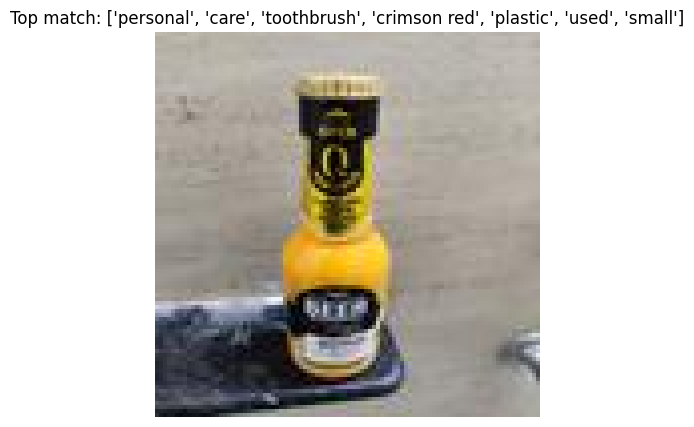

In [ ]:
# ----- DEMO -----
query = "toothbrush"
results = retrieve_images(query, search_index, top_k=5)

if results:
    print(f"\nTop results for: '{query}'")
    for r in results:
        print(f"Score: {r['score']} | Tags: {r['tags']} | {r['image_path']}")
    # visualize top hit
    img = Image.open(results[0]["image_path"])
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.title(f"Top match: {results[0]['tags']}")
    plt.axis("off")
    plt.show()
else:
    print("No matches found.")